# DataTalksClub MLZoomcamp Capstone Project 2

In this project we will try to create an ML model that would be able to take a photo of an adult penguin and determine its species. 

## Getting data

I have not found a suitable dataset for my idea, so I had to create one myself. This was my first experience with scraping images from the web and with creating my own dataset in general. 

With some tweaks, I used [this convenient library](https://github.com/ohyicong/Google-Image-Scraper) to download the images. This library is based on GoogleImageScraper and was created to bypass some restrictions on web scraping from Google Images. The link above incluced the instructions on how to install the library and run the script. The only thing that is not mentioned there is that, at least on MacOS, one needs to manually download and install a chrome driver (in my case, from https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/122.0.6192.0/mac-x64/chromedriver-mac-x64.zip). After this, I ran the script to download 300 photos of each penguin species in my list from Google search. However, for some reason this did not work equally well for all species. For some classes I ended up with way fewer pictures. Then, when the pictures were saved, I had to go through all of them manually and remove quite a lot of pictures from each class, because they were not suitable for training. This included some duplicates, pictures with multiple species in one photo, pictures of very cute little chicks (however cute, they all kind of look the same), non-realistic drawings, photos of plush toys and some rubbish. 


The result was uploaded as a Kaggle dataset [here](https://www.kaggle.com/datasets/nordskova/penguin-species-photos/). 

In [35]:
labels = ["emperor_penguin","adelie_penguin","chinstrap_penguin",
          "southern_rockhopper_penguin","northern_rockhopper_penguin",
          "fiordland_penguin","snares_penguin","macaroni_penguin",
          "yellow_eyed_penguin","african penguin", "humboldt_penguin",
          "magellanic_penguin","galapagos_penguin"]

print(f"We will work with {len(labels)} species of penguins!")

We will work with 13 species of penguins!


As mentioned above, after scraping our classes were somewhat unbalanced. Let's see how significant this problem is and try to fix it with augmentation. Also, we will need to rescale our images to the same size, convert them into RGB and later convert to Pytorch tensors. 

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/penguin-species-photos/photos'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import pandas as pd

import pickle
import numpy as np
from skimage import io
import requests
from bs4 import BeautifulSoup
import math
import random
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from urllib.parse import quote_plus


from torchvision import transforms, models, datasets
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import io

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In Kaggle, the input directory is read-only, so first we will copy our data to /kaggle/working. 

In [37]:
!cp -r "/kaggle/input/penguin-species-photos/photos" "./"

In [38]:
seed = 1 #fixing the random seed
img_size = 224 #the images will be rescaled to be 224 by 224 pixels 
batch_size = 64 #fixing the batch size here as well 

DEVICE = torch.device("cuda")

In [39]:
train_path = Path('/kaggle/working/photos')

train_val_files = sorted(list(train_path.rglob('*.jpeg')))
train_val_labels = [i.parent.name for i in train_val_files]
data = pd.Series(train_val_labels).value_counts().sort_values().to_frame("count")
data

,count
adelie_penguin,300
african_penguin,300
chinstrap_penguin,300
emperor_penguin,300
fiordland_penguin,300
galapagos_penguin,300
humboldt_penguin,300
macaroni_penguin,300
magellanic_penguin,300
northern_rockhopper_penguin,300


We can see that the classes are somewhat unbalanced. Let us add more pictures by applying random transformations (crops, flips and rotations) to the existing ones. I have learned the following method from [this notebook](https://www.kaggle.com/code/marinalakeeva/data-augmentation/notebook). 

In [40]:
data['needed'] = data['count'].apply(lambda x: 300 - x if x < 300 else 0)
data['batch'] = data.apply(lambda x: math.ceil(x['needed'] / x['count']), axis=1)
data

,count,needed,batch
adelie_penguin,300,0,0
african_penguin,300,0,0
chinstrap_penguin,300,0,0
emperor_penguin,300,0,0
fiordland_penguin,300,0,0
galapagos_penguin,300,0,0
humboldt_penguin,300,0,0
macaroni_penguin,300,0,0
magellanic_penguin,300,0,0
northern_rockhopper_penguin,300,0,0


In [41]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1), 
}


def load_sample(file):
    image = Image.open(file)
    image.load()
    return image

for image_path in tqdm(train_val_files):
    path = image_path.parents[0]
    species = image_path.parent.name
    img = load_sample(image_path)
    
    if data['needed'][species] <= 0: #if we already have 300 images of this species, we don't add anything
        continue
        
 #if the size of the batch is greater than the number of pictures we need, replace it with data['needed']. 
    if data['batch'][species] > data['needed'][species]: 
        iter_size = data.loc[species]['needed']
    else:
        iter_size = data['batch'][species] 
    data['needed'][species] = data['needed'][species] - iter_size
    #print("needed: ", data['needed'][species], "itersize: ", iter_size, "species: ", species)
    
    for i in range(iter_size):
        augment = random.choice(list(augmenters.values()))
        aug_img = augment(img).convert('RGB')
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpeg")

100%|██████████| 3900/3900 [00:19<00:00, 195.09it/s]


Let's make sure that we have balanced classes now, each containing 300 pictures. 

In [42]:
train_path = Path('/kaggle/working/photos')
train_val_files = sorted(list(train_path.rglob('*.jpeg')))
train_val_labels = [i.parent.name for i in train_val_files]
data = pd.Series(train_val_labels).value_counts().sort_values().to_frame("count")
data

,count
adelie_penguin,300
african_penguin,300
chinstrap_penguin,300
emperor_penguin,300
fiordland_penguin,300
galapagos_penguin,300
humboldt_penguin,300
macaroni_penguin,300
magellanic_penguin,300
northern_rockhopper_penguin,300


Now let's split the data into train and validation parts. 

In [43]:
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

Then we normalize/rescale the images and transform them into Torch tensors. Many things below I have learned from another online course, namely, Deep Learning School by MIPT. Some parts of the code are also borrowed from examples provided by Pytorch in their documentation/tutorials.

In [44]:
data_modes = ['train', 'val', 'test']
class peng_dataset(Dataset):
    
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image.convert('RGB')

    def __getitem__(self, index):
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        X = self.load_sample(self.files[index])
        X = self._prepare_sample(X)
        X = np.array(X / 255, dtype='float32')
        X = preprocess(X)
        if self.mode == 'test':
            return X
        else:
            label = self.labels[index]
            y = self.label_encoder.transform([label]).item()
            return X, y

    def _prepare_sample(self, image):
        image = image.convert('RGB').resize((img_size, img_size))
        return np.array(image)

Creating two datasets with Pytorch tensors: 

In [45]:
train_dataset = peng_dataset(train_files, mode='train')
val_dataset = peng_dataset(val_files, mode='val')

Now let us also create an imshow function for tensors and display a few images just to see what we have here. 

In [46]:
def imshow(inp, title=None, plt_ax=plt):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    plt_ax.set_title(title)
    plt_ax.grid(False)



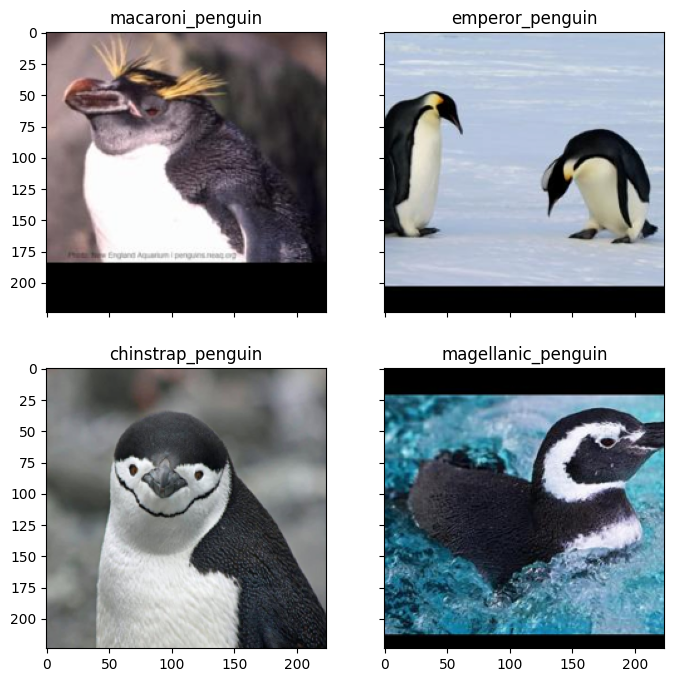

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    rands = int(np.random.uniform(0,2000))
    img_val, label = train_dataset[rands]
    img_label =  val_dataset.label_encoder.inverse_transform([label])[0]
    imshow(img_val.data.cpu(),title=img_label,plt_ax=fig_x)

## Resnet50 

Finally, our data is ready and we can proceed to training. First, let's use a pretrained Resnet50 model.

In [25]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
num_features = 2048
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Dropout(0.3),
               nn.Linear(128, 13))

resnet50_model = model.to(DEVICE)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We will need some functions to train, evaluate and predict. 

Training within one epoch: 

In [47]:
def fit_epoch(model, train_loader, criterion, optimizer):
    
    model.train(True)

    total_loss = 0
    total_true = 0
    count_data = 0
    
    
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        total_loss += loss.item() * inputs.size(0)
        total_true += torch.sum(preds == labels.data)
        count_data += inputs.size(0)

    train_loss = total_loss/count_data
    train_accuracy = total_true.cpu().numpy()/count_data
    return train_loss, train_accuracy

Evaluating the results of training on one epoch: 

In [48]:
def eval_epoch(model, val_loader, criterion):
    
    model.eval()
    total_loss = 0
    total_true = 0
    count_data = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
        
    
        total_loss += loss.item() * inputs.size(0)
        total_true += torch.sum(preds == labels.data)
        count_data += inputs.size(0)
      
    val_loss = total_loss/count_data
    val_accuracy = total_true.double()/count_data
    
    return val_loss, val_accuracy

Creating train and val dataloaders, training for the requested number of epochs and saving the evalutaion results. We will use a progress bar to display the results of our training along the way. We are using cross entropy as our loss function since we deal with a multi class classification.

In [16]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

    
    history = []


    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()
        
    
        for epoch in range(epochs):
            train_loss, train_accuracy = fit_epoch(model, train_loader, criterion, opt)
            #print("train loss: ", train_loss)
            val_loss, val_accuracy = eval_epoch(model, val_loader, criterion)
            #print("val loss: ", val_loss)

            history.append((train_loss, train_accuracy, val_loss, val_accuracy))
            pbar_outer.update(1)
            logs = "\nEpoch {ep} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
            tqdm.write(logs.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_accuracy, v_acc=val_accuracy))

    return history

Finally, a prediction function. 

In [49]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    return nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

Let's train for 120 epochs. 

In [27]:
history = train(train_dataset, val_dataset, model=resnet50_model, epochs=120, batch_size=batch_size)

epoch:   0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   1%|          | 1/120 [01:14<2:26:57, 74.10s/it]


Epoch 1 train_loss: 2.2225 val_loss 2.0967 train_acc 0.3675 val_acc 0.5231


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   2%|▏         | 2/120 [02:27<2:25:27, 73.96s/it]


Epoch 2 train_loss: 1.9976 val_loss 1.8775 train_acc 0.4872 val_acc 0.6390


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   2%|▎         | 3/120 [03:41<2:24:04, 73.89s/it]


Epoch 3 train_loss: 1.7866 val_loss 1.6979 train_acc 0.5562 val_acc 0.6472


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   3%|▎         | 4/120 [04:55<2:23:03, 74.00s/it]


Epoch 4 train_loss: 1.6301 val_loss 1.5440 train_acc 0.5918 val_acc 0.6810


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   4%|▍         | 5/120 [06:09<2:21:41, 73.93s/it]


Epoch 5 train_loss: 1.5025 val_loss 1.4227 train_acc 0.6212 val_acc 0.7005


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   5%|▌         | 6/120 [07:23<2:20:32, 73.97s/it]


Epoch 6 train_loss: 1.3770 val_loss 1.3210 train_acc 0.6400 val_acc 0.7077


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   6%|▌         | 7/120 [08:37<2:19:18, 73.97s/it]


Epoch 7 train_loss: 1.2835 val_loss 1.2430 train_acc 0.6653 val_acc 0.7005


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   7%|▋         | 8/120 [09:51<2:18:11, 74.03s/it]


Epoch 8 train_loss: 1.2007 val_loss 1.1716 train_acc 0.6879 val_acc 0.7169


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   8%|▊         | 9/120 [11:05<2:16:55, 74.01s/it]


Epoch 9 train_loss: 1.1357 val_loss 1.1148 train_acc 0.7002 val_acc 0.7179


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   8%|▊         | 10/120 [12:19<2:15:41, 74.01s/it]


Epoch 10 train_loss: 1.0832 val_loss 1.0646 train_acc 0.7053 val_acc 0.7282


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   9%|▉         | 11/120 [13:33<2:14:21, 73.96s/it]


Epoch 11 train_loss: 1.0450 val_loss 1.0265 train_acc 0.7032 val_acc 0.7415


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  10%|█         | 12/120 [14:47<2:13:05, 73.94s/it]


Epoch 12 train_loss: 0.9925 val_loss 0.9846 train_acc 0.7337 val_acc 0.7374


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  11%|█         | 13/120 [16:01<2:11:44, 73.88s/it]


Epoch 13 train_loss: 0.9571 val_loss 0.9549 train_acc 0.7405 val_acc 0.7651


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  12%|█▏        | 14/120 [17:15<2:10:30, 73.87s/it]


Epoch 14 train_loss: 0.9306 val_loss 0.9165 train_acc 0.7446 val_acc 0.7631


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  12%|█▎        | 15/120 [18:29<2:09:24, 73.95s/it]


Epoch 15 train_loss: 0.8930 val_loss 0.8964 train_acc 0.7484 val_acc 0.7641


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  13%|█▎        | 16/120 [19:43<2:08:10, 73.94s/it]


Epoch 16 train_loss: 0.8583 val_loss 0.8733 train_acc 0.7535 val_acc 0.7764


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  14%|█▍        | 17/120 [20:57<2:06:58, 73.97s/it]


Epoch 17 train_loss: 0.8313 val_loss 0.8444 train_acc 0.7706 val_acc 0.7723


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  15%|█▌        | 18/120 [22:11<2:05:48, 74.01s/it]


Epoch 18 train_loss: 0.7869 val_loss 0.8222 train_acc 0.7774 val_acc 0.7785


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  16%|█▌        | 19/120 [23:25<2:04:38, 74.04s/it]


Epoch 19 train_loss: 0.7879 val_loss 0.8149 train_acc 0.7641 val_acc 0.7682


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  17%|█▋        | 20/120 [24:39<2:03:20, 74.00s/it]


Epoch 20 train_loss: 0.7442 val_loss 0.7885 train_acc 0.7925 val_acc 0.7897


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  18%|█▊        | 21/120 [25:53<2:02:02, 73.96s/it]


Epoch 21 train_loss: 0.7395 val_loss 0.7739 train_acc 0.7853 val_acc 0.7826


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  18%|█▊        | 22/120 [27:07<2:00:55, 74.04s/it]


Epoch 22 train_loss: 0.7157 val_loss 0.7653 train_acc 0.7863 val_acc 0.7908


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  19%|█▉        | 23/120 [28:22<2:00:08, 74.31s/it]


Epoch 23 train_loss: 0.7101 val_loss 0.7565 train_acc 0.7904 val_acc 0.7815


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  20%|██        | 24/120 [29:36<1:58:41, 74.18s/it]


Epoch 24 train_loss: 0.6892 val_loss 0.7411 train_acc 0.8099 val_acc 0.7867


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  21%|██        | 25/120 [30:50<1:57:23, 74.14s/it]


Epoch 25 train_loss: 0.6618 val_loss 0.7331 train_acc 0.8150 val_acc 0.7928


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  22%|██▏       | 26/120 [32:04<1:56:16, 74.22s/it]


Epoch 26 train_loss: 0.6619 val_loss 0.7146 train_acc 0.8147 val_acc 0.8041


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  22%|██▎       | 27/120 [33:19<1:55:04, 74.25s/it]


Epoch 27 train_loss: 0.6488 val_loss 0.7058 train_acc 0.8181 val_acc 0.8041


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  23%|██▎       | 28/120 [34:33<1:53:43, 74.16s/it]


Epoch 28 train_loss: 0.6374 val_loss 0.7024 train_acc 0.8109 val_acc 0.8000


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  24%|██▍       | 29/120 [35:46<1:52:16, 74.03s/it]


Epoch 29 train_loss: 0.6077 val_loss 0.6842 train_acc 0.8198 val_acc 0.8051


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  25%|██▌       | 30/120 [37:00<1:50:53, 73.93s/it]


Epoch 30 train_loss: 0.5964 val_loss 0.6820 train_acc 0.8311 val_acc 0.8041


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  26%|██▌       | 31/120 [38:14<1:49:32, 73.85s/it]


Epoch 31 train_loss: 0.5988 val_loss 0.6719 train_acc 0.8260 val_acc 0.8072


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  27%|██▋       | 32/120 [39:27<1:48:12, 73.78s/it]


Epoch 32 train_loss: 0.5778 val_loss 0.6685 train_acc 0.8287 val_acc 0.8072


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  28%|██▊       | 33/120 [40:41<1:46:56, 73.76s/it]


Epoch 33 train_loss: 0.5728 val_loss 0.6566 train_acc 0.8356 val_acc 0.8103


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  28%|██▊       | 34/120 [41:54<1:45:34, 73.65s/it]


Epoch 34 train_loss: 0.5635 val_loss 0.6492 train_acc 0.8349 val_acc 0.8082


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  29%|██▉       | 35/120 [43:08<1:44:18, 73.63s/it]


Epoch 35 train_loss: 0.5442 val_loss 0.6515 train_acc 0.8421 val_acc 0.8133


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  30%|███       | 36/120 [44:22<1:43:10, 73.70s/it]


Epoch 36 train_loss: 0.5456 val_loss 0.6382 train_acc 0.8376 val_acc 0.8092


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  31%|███       | 37/120 [45:36<1:42:01, 73.75s/it]


Epoch 37 train_loss: 0.5272 val_loss 0.6339 train_acc 0.8448 val_acc 0.8041


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  32%|███▏      | 38/120 [46:49<1:40:44, 73.71s/it]


Epoch 38 train_loss: 0.5236 val_loss 0.6268 train_acc 0.8523 val_acc 0.8144


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  32%|███▎      | 39/120 [48:03<1:39:27, 73.67s/it]


Epoch 39 train_loss: 0.5191 val_loss 0.6283 train_acc 0.8540 val_acc 0.8123


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  33%|███▎      | 40/120 [49:17<1:38:20, 73.75s/it]


Epoch 40 train_loss: 0.5039 val_loss 0.6227 train_acc 0.8550 val_acc 0.8185


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  34%|███▍      | 41/120 [50:31<1:37:06, 73.76s/it]


Epoch 41 train_loss: 0.5084 val_loss 0.6096 train_acc 0.8462 val_acc 0.8185


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  35%|███▌      | 42/120 [51:45<1:35:59, 73.84s/it]


Epoch 42 train_loss: 0.4993 val_loss 0.6064 train_acc 0.8550 val_acc 0.8256


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  36%|███▌      | 43/120 [52:58<1:34:38, 73.74s/it]


Epoch 43 train_loss: 0.4913 val_loss 0.6028 train_acc 0.8496 val_acc 0.8185


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  37%|███▋      | 44/120 [54:12<1:33:26, 73.77s/it]


Epoch 44 train_loss: 0.4693 val_loss 0.5967 train_acc 0.8564 val_acc 0.8185


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  38%|███▊      | 45/120 [55:26<1:32:10, 73.74s/it]


Epoch 45 train_loss: 0.4642 val_loss 0.5939 train_acc 0.8615 val_acc 0.8195


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  38%|███▊      | 46/120 [56:40<1:31:00, 73.79s/it]


Epoch 46 train_loss: 0.4677 val_loss 0.5877 train_acc 0.8602 val_acc 0.8256


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  39%|███▉      | 47/120 [57:53<1:29:43, 73.75s/it]


Epoch 47 train_loss: 0.4583 val_loss 0.5814 train_acc 0.8653 val_acc 0.8215


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  40%|████      | 48/120 [59:07<1:28:31, 73.77s/it]


Epoch 48 train_loss: 0.4429 val_loss 0.5861 train_acc 0.8762 val_acc 0.8215


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  41%|████      | 49/120 [1:00:21<1:27:18, 73.78s/it]


Epoch 49 train_loss: 0.4398 val_loss 0.5864 train_acc 0.8687 val_acc 0.8205


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  42%|████▏     | 50/120 [1:01:35<1:26:07, 73.82s/it]


Epoch 50 train_loss: 0.4282 val_loss 0.5761 train_acc 0.8721 val_acc 0.8164


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  42%|████▎     | 51/120 [1:02:49<1:24:52, 73.80s/it]


Epoch 51 train_loss: 0.4417 val_loss 0.5758 train_acc 0.8646 val_acc 0.8215


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  43%|████▎     | 52/120 [1:04:02<1:23:31, 73.70s/it]


Epoch 52 train_loss: 0.4305 val_loss 0.5710 train_acc 0.8715 val_acc 0.8164


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  44%|████▍     | 53/120 [1:05:16<1:22:28, 73.86s/it]


Epoch 53 train_loss: 0.4159 val_loss 0.5672 train_acc 0.8762 val_acc 0.8195


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  45%|████▌     | 54/120 [1:06:30<1:21:16, 73.89s/it]


Epoch 54 train_loss: 0.4147 val_loss 0.5667 train_acc 0.8766 val_acc 0.8328


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  46%|████▌     | 55/120 [1:07:44<1:20:03, 73.91s/it]


Epoch 55 train_loss: 0.4119 val_loss 0.5668 train_acc 0.8773 val_acc 0.8154


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  47%|████▋     | 56/120 [1:08:58<1:18:49, 73.90s/it]


Epoch 56 train_loss: 0.4008 val_loss 0.5683 train_acc 0.8824 val_acc 0.8226


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  48%|████▊     | 57/120 [1:10:12<1:17:40, 73.98s/it]


Epoch 57 train_loss: 0.3929 val_loss 0.5564 train_acc 0.8824 val_acc 0.8154


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  48%|████▊     | 58/120 [1:11:26<1:16:21, 73.90s/it]


Epoch 58 train_loss: 0.3862 val_loss 0.5500 train_acc 0.8885 val_acc 0.8164


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  49%|████▉     | 59/120 [1:12:40<1:15:04, 73.85s/it]


Epoch 59 train_loss: 0.3979 val_loss 0.5472 train_acc 0.8834 val_acc 0.8215


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  50%|█████     | 60/120 [1:13:53<1:13:50, 73.84s/it]


Epoch 60 train_loss: 0.3843 val_loss 0.5441 train_acc 0.8920 val_acc 0.8308


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  51%|█████     | 61/120 [1:15:07<1:12:34, 73.81s/it]


Epoch 61 train_loss: 0.3882 val_loss 0.5441 train_acc 0.8906 val_acc 0.8226


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  52%|█████▏    | 62/120 [1:16:21<1:11:24, 73.88s/it]


Epoch 62 train_loss: 0.3676 val_loss 0.5401 train_acc 0.8950 val_acc 0.8318


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  52%|█████▎    | 63/120 [1:17:35<1:10:08, 73.83s/it]


Epoch 63 train_loss: 0.3701 val_loss 0.5363 train_acc 0.8940 val_acc 0.8246


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  53%|█████▎    | 64/120 [1:18:49<1:08:56, 73.87s/it]


Epoch 64 train_loss: 0.3642 val_loss 0.5321 train_acc 0.8940 val_acc 0.8297


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  54%|█████▍    | 65/120 [1:20:03<1:07:46, 73.94s/it]


Epoch 65 train_loss: 0.3666 val_loss 0.5337 train_acc 0.8913 val_acc 0.8226


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  55%|█████▌    | 66/120 [1:21:17<1:06:29, 73.88s/it]


Epoch 66 train_loss: 0.3541 val_loss 0.5393 train_acc 0.9019 val_acc 0.8185


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  56%|█████▌    | 67/120 [1:22:30<1:05:11, 73.79s/it]


Epoch 67 train_loss: 0.3609 val_loss 0.5346 train_acc 0.8923 val_acc 0.8338


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  57%|█████▋    | 68/120 [1:23:44<1:03:58, 73.83s/it]


Epoch 68 train_loss: 0.3483 val_loss 0.5305 train_acc 0.9022 val_acc 0.8328


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  57%|█████▊    | 69/120 [1:24:58<1:02:44, 73.81s/it]


Epoch 69 train_loss: 0.3341 val_loss 0.5239 train_acc 0.9005 val_acc 0.8277


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  58%|█████▊    | 70/120 [1:26:12<1:01:35, 73.90s/it]


Epoch 70 train_loss: 0.3465 val_loss 0.5250 train_acc 0.8998 val_acc 0.8318


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  59%|█████▉    | 71/120 [1:27:26<1:00:20, 73.89s/it]


Epoch 71 train_loss: 0.3356 val_loss 0.5265 train_acc 0.9060 val_acc 0.8277


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  60%|██████    | 72/120 [1:28:40<59:05, 73.86s/it]  


Epoch 72 train_loss: 0.3348 val_loss 0.5209 train_acc 0.9012 val_acc 0.8328


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  61%|██████    | 73/120 [1:29:54<57:51, 73.87s/it]


Epoch 73 train_loss: 0.3294 val_loss 0.5222 train_acc 0.8981 val_acc 0.8287


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  62%|██████▏   | 74/120 [1:31:07<56:36, 73.85s/it]


Epoch 74 train_loss: 0.3280 val_loss 0.5157 train_acc 0.9046 val_acc 0.8308


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  62%|██████▎   | 75/120 [1:32:21<55:24, 73.87s/it]


Epoch 75 train_loss: 0.3206 val_loss 0.5106 train_acc 0.9121 val_acc 0.8318


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  63%|██████▎   | 76/120 [1:33:35<54:09, 73.86s/it]


Epoch 76 train_loss: 0.3209 val_loss 0.5149 train_acc 0.9050 val_acc 0.8297


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  64%|██████▍   | 77/120 [1:34:49<52:55, 73.85s/it]


Epoch 77 train_loss: 0.3061 val_loss 0.5157 train_acc 0.9053 val_acc 0.8379


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  65%|██████▌   | 78/120 [1:36:03<51:44, 73.92s/it]


Epoch 78 train_loss: 0.2979 val_loss 0.5083 train_acc 0.9162 val_acc 0.8338


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  66%|██████▌   | 79/120 [1:37:17<50:27, 73.85s/it]


Epoch 79 train_loss: 0.3134 val_loss 0.5101 train_acc 0.9097 val_acc 0.8308


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  67%|██████▋   | 80/120 [1:38:31<49:14, 73.87s/it]


Epoch 80 train_loss: 0.2987 val_loss 0.5087 train_acc 0.9149 val_acc 0.8338


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  68%|██████▊   | 81/120 [1:39:44<47:59, 73.84s/it]


Epoch 81 train_loss: 0.3090 val_loss 0.5023 train_acc 0.9053 val_acc 0.8379


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  68%|██████▊   | 82/120 [1:40:58<46:46, 73.85s/it]


Epoch 82 train_loss: 0.2908 val_loss 0.5019 train_acc 0.9128 val_acc 0.8369


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  69%|██████▉   | 83/120 [1:42:12<45:33, 73.87s/it]


Epoch 83 train_loss: 0.2937 val_loss 0.5020 train_acc 0.9121 val_acc 0.8400


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  70%|███████   | 84/120 [1:43:27<44:23, 73.98s/it]


Epoch 84 train_loss: 0.2841 val_loss 0.5023 train_acc 0.9176 val_acc 0.8379


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  71%|███████   | 85/120 [1:44:41<43:09, 73.99s/it]


Epoch 85 train_loss: 0.2906 val_loss 0.5030 train_acc 0.9149 val_acc 0.8349


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  72%|███████▏  | 86/120 [1:45:55<41:55, 74.00s/it]


Epoch 86 train_loss: 0.2771 val_loss 0.5010 train_acc 0.9190 val_acc 0.8379


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  72%|███████▎  | 87/120 [1:47:08<40:38, 73.90s/it]


Epoch 87 train_loss: 0.2766 val_loss 0.5050 train_acc 0.9210 val_acc 0.8338


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  73%|███████▎  | 88/120 [1:48:22<39:22, 73.83s/it]


Epoch 88 train_loss: 0.2807 val_loss 0.4941 train_acc 0.9200 val_acc 0.8369


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  74%|███████▍  | 89/120 [1:49:36<38:10, 73.87s/it]


Epoch 89 train_loss: 0.2640 val_loss 0.4952 train_acc 0.9255 val_acc 0.8400


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  75%|███████▌  | 90/120 [1:50:50<36:54, 73.82s/it]


Epoch 90 train_loss: 0.2683 val_loss 0.5008 train_acc 0.9244 val_acc 0.8421


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  76%|███████▌  | 91/120 [1:52:04<35:42, 73.87s/it]


Epoch 91 train_loss: 0.2714 val_loss 0.4954 train_acc 0.9210 val_acc 0.8359


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  77%|███████▋  | 92/120 [1:53:17<34:26, 73.81s/it]


Epoch 92 train_loss: 0.2753 val_loss 0.5000 train_acc 0.9203 val_acc 0.8328


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  78%|███████▊  | 93/120 [1:54:31<33:15, 73.90s/it]


Epoch 93 train_loss: 0.2623 val_loss 0.4927 train_acc 0.9272 val_acc 0.8421


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  78%|███████▊  | 94/120 [1:55:46<32:05, 74.04s/it]


Epoch 94 train_loss: 0.2594 val_loss 0.4913 train_acc 0.9248 val_acc 0.8369


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  79%|███████▉  | 95/120 [1:57:00<30:50, 74.01s/it]


Epoch 95 train_loss: 0.2539 val_loss 0.4967 train_acc 0.9289 val_acc 0.8400


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  80%|████████  | 96/120 [1:58:13<29:34, 73.94s/it]


Epoch 96 train_loss: 0.2564 val_loss 0.4927 train_acc 0.9282 val_acc 0.8359


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  81%|████████  | 97/120 [1:59:27<28:20, 73.91s/it]


Epoch 97 train_loss: 0.2469 val_loss 0.4927 train_acc 0.9333 val_acc 0.8431


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  82%|████████▏ | 98/120 [2:00:41<27:07, 73.98s/it]


Epoch 98 train_loss: 0.2527 val_loss 0.4901 train_acc 0.9272 val_acc 0.8318


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  82%|████████▎ | 99/120 [2:01:56<25:56, 74.10s/it]


Epoch 99 train_loss: 0.2532 val_loss 0.4835 train_acc 0.9285 val_acc 0.8390


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  83%|████████▎ | 100/120 [2:03:10<24:42, 74.11s/it]


Epoch 100 train_loss: 0.2456 val_loss 0.4955 train_acc 0.9289 val_acc 0.8400


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  84%|████████▍ | 101/120 [2:04:24<23:28, 74.11s/it]


Epoch 101 train_loss: 0.2431 val_loss 0.4887 train_acc 0.9323 val_acc 0.8369


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  85%|████████▌ | 102/120 [2:05:38<22:13, 74.09s/it]


Epoch 102 train_loss: 0.2389 val_loss 0.4811 train_acc 0.9289 val_acc 0.8441


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  86%|████████▌ | 103/120 [2:06:52<20:59, 74.10s/it]


Epoch 103 train_loss: 0.2219 val_loss 0.4914 train_acc 0.9439 val_acc 0.8338


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  87%|████████▋ | 104/120 [2:08:06<19:44, 74.02s/it]


Epoch 104 train_loss: 0.2447 val_loss 0.4817 train_acc 0.9268 val_acc 0.8390


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  88%|████████▊ | 105/120 [2:09:20<18:30, 74.03s/it]


Epoch 105 train_loss: 0.2271 val_loss 0.4847 train_acc 0.9385 val_acc 0.8359


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  88%|████████▊ | 106/120 [2:10:34<17:15, 74.00s/it]


Epoch 106 train_loss: 0.2257 val_loss 0.4827 train_acc 0.9368 val_acc 0.8441


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  89%|████████▉ | 107/120 [2:11:48<16:02, 74.06s/it]


Epoch 107 train_loss: 0.2244 val_loss 0.4826 train_acc 0.9388 val_acc 0.8400


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  90%|█████████ | 108/120 [2:13:03<14:50, 74.20s/it]


Epoch 108 train_loss: 0.2238 val_loss 0.4882 train_acc 0.9364 val_acc 0.8390


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  91%|█████████ | 109/120 [2:14:17<13:37, 74.31s/it]


Epoch 109 train_loss: 0.2391 val_loss 0.4865 train_acc 0.9326 val_acc 0.8441


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  92%|█████████▏| 110/120 [2:15:32<12:22, 74.28s/it]


Epoch 110 train_loss: 0.2232 val_loss 0.4798 train_acc 0.9374 val_acc 0.8379


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  92%|█████████▎| 111/120 [2:16:46<11:08, 74.29s/it]


Epoch 111 train_loss: 0.2152 val_loss 0.4811 train_acc 0.9463 val_acc 0.8400


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  93%|█████████▎| 112/120 [2:18:00<09:53, 74.19s/it]


Epoch 112 train_loss: 0.2119 val_loss 0.4782 train_acc 0.9368 val_acc 0.8421


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  94%|█████████▍| 113/120 [2:19:14<08:39, 74.20s/it]


Epoch 113 train_loss: 0.2109 val_loss 0.4828 train_acc 0.9426 val_acc 0.8462


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  95%|█████████▌| 114/120 [2:20:28<07:25, 74.18s/it]


Epoch 114 train_loss: 0.2077 val_loss 0.4753 train_acc 0.9429 val_acc 0.8462


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  96%|█████████▌| 115/120 [2:21:42<06:10, 74.19s/it]


Epoch 115 train_loss: 0.2046 val_loss 0.4862 train_acc 0.9432 val_acc 0.8462


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  97%|█████████▋| 116/120 [2:22:57<04:57, 74.31s/it]


Epoch 116 train_loss: 0.2126 val_loss 0.4799 train_acc 0.9378 val_acc 0.8349


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  98%|█████████▊| 117/120 [2:24:11<03:42, 74.25s/it]


Epoch 117 train_loss: 0.2105 val_loss 0.4835 train_acc 0.9456 val_acc 0.8421


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  98%|█████████▊| 118/120 [2:25:26<02:28, 74.37s/it]


Epoch 118 train_loss: 0.1996 val_loss 0.4806 train_acc 0.9439 val_acc 0.8451


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  99%|█████████▉| 119/120 [2:26:40<01:14, 74.36s/it]


Epoch 119 train_loss: 0.2036 val_loss 0.4815 train_acc 0.9412 val_acc 0.8503


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch: 100%|██████████| 120/120 [2:27:54<00:00, 73.96s/it]


Epoch 120 train_loss: 0.2016 val_loss 0.4741 train_acc 0.9470 val_acc 0.8390


Let's visualize how our losses and accuracies have improved over the course of the training. 

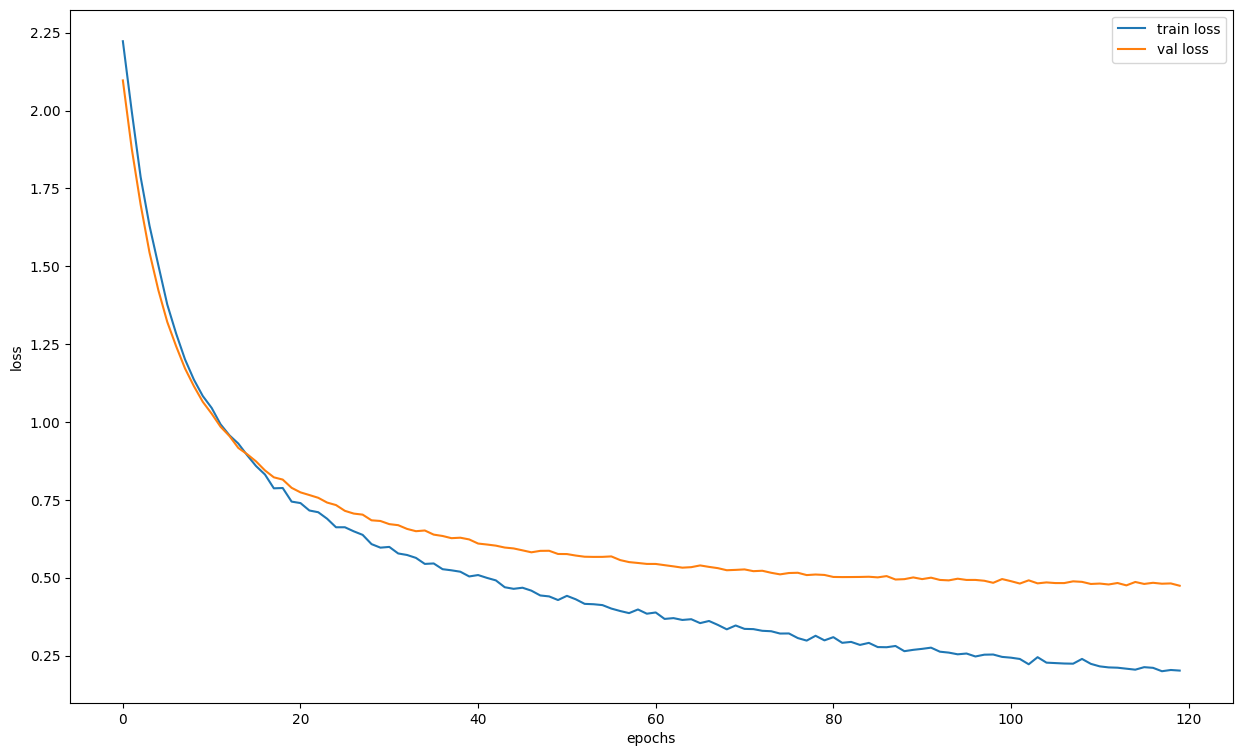

In [28]:
train_loss, train_accuracy, val_loss, val_accuracy = zip(*history) 
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Not bad, but the val loss doesn't improve much beyond 80-100 epochs.  

When dealing with multi-label classification, it is useful to calculate the F1-score in order to see how well our model is doing and be able to compare it to other models in the future. Let's use random 100 images from the validation dataset. 

In [29]:
idx = list(map(int, np.random.uniform(0,500,100)))
imgs = [val_dataset[i][0].unsqueeze(0) for i in idx]
probs = predict(resnet50_model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = np.argmax(probs,-1)
actual_species = [val_dataset[i][1] for i in idx]
print("F1-score for Resnet50:", f1_score(actual_species, preds, average='micro'))

F1-score for Resnet50: 0.83


Finally, let's visualize some of our predictions. We are going to need another function for predictions, this time for just one sample. It will be useful later as well. 

In [50]:
def predict_one(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Prediction: african_penguin with confidence 100%
Prediction: galapagos_penguin with confidence 100%
Prediction: fiordland_penguin with confidence 99%
Prediction: adelie_penguin with confidence 100%
Prediction: adelie_penguin with confidence 100%


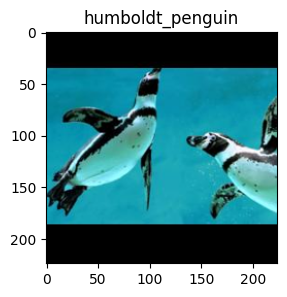

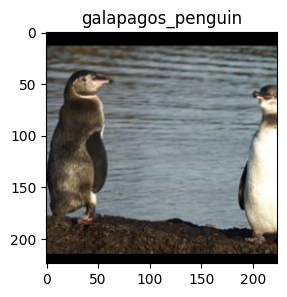

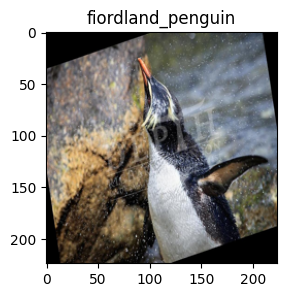

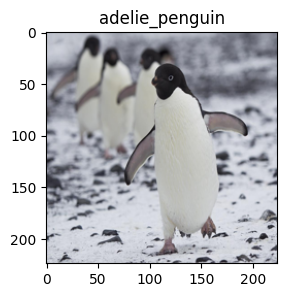

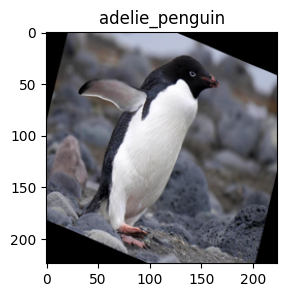

In [43]:
for _ in range(5):
    rands = int(np.random.uniform(0,500))
    img, label = val_dataset[rands]
    actual_species = val_dataset.label_encoder.inverse_transform([label])[0]
    prob = predict_one(resnet50_model, img.unsqueeze(0))
    predict_proba = np.max(prob)*100
    
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3, 3))
    imshow(img.data.cpu(),title=actual_species,plt_ax=ax)
    predicted_species = label_encoder.classes_[np.argmax(prob)]
    print("Prediction: {} with confidence {:.0f}%".format(predicted_species,predict_proba)) 


We can see one mistake here: the first sample picture is predicted as an African penguin with 100% confidence, while it is labeled as a Humboldt penguin. To be honest, I am not sure the label here is correct, but these two seem to be very hard to distinguish. 

In [44]:
torch.save(resnet50_model, '/kaggle/working/resnet50_model.pth')

## MobileNet V2 

In [15]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
mobnet_model = model.to(DEVICE)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 112MB/s] 


Let's train for 30 epochs using the same functions as for Resnet50. 

In [16]:
history = train(train_dataset, val_dataset, model=mobnet_model, epochs=30, batch_size=batch_size)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   3%|▎         | 1/30 [01:18<38:09, 78.94s/it]


Epoch 1 train_loss: 3.8196 val_loss 1.1568 train_acc 0.4253 val_acc 0.7231


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   7%|▋         | 2/30 [02:36<36:20, 77.88s/it]


Epoch 2 train_loss: 0.5321 val_loss 0.6759 train_acc 0.8520 val_acc 0.8215


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  10%|█         | 3/30 [03:54<35:03, 77.92s/it]


Epoch 3 train_loss: 0.2151 val_loss 0.5810 train_acc 0.9402 val_acc 0.8451


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  13%|█▎        | 4/30 [05:11<33:42, 77.79s/it]


Epoch 4 train_loss: 0.1113 val_loss 0.5605 train_acc 0.9761 val_acc 0.8544


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  17%|█▋        | 5/30 [06:30<32:33, 78.14s/it]


Epoch 5 train_loss: 0.0743 val_loss 0.5401 train_acc 0.9867 val_acc 0.8605


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  20%|██        | 6/30 [07:48<31:17, 78.24s/it]


Epoch 6 train_loss: 0.0528 val_loss 0.5597 train_acc 0.9915 val_acc 0.8615


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  23%|██▎       | 7/30 [09:07<30:00, 78.29s/it]


Epoch 7 train_loss: 0.0553 val_loss 0.5631 train_acc 0.9877 val_acc 0.8667


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  27%|██▋       | 8/30 [10:25<28:40, 78.21s/it]


Epoch 8 train_loss: 0.0369 val_loss 0.5373 train_acc 0.9925 val_acc 0.8708


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  30%|███       | 9/30 [11:43<27:23, 78.25s/it]


Epoch 9 train_loss: 0.0363 val_loss 0.5724 train_acc 0.9918 val_acc 0.8677


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  33%|███▎      | 10/30 [13:01<26:03, 78.19s/it]


Epoch 10 train_loss: 0.0376 val_loss 0.5500 train_acc 0.9915 val_acc 0.8687


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  37%|███▋      | 11/30 [14:19<24:46, 78.22s/it]


Epoch 11 train_loss: 0.0346 val_loss 0.5521 train_acc 0.9928 val_acc 0.8728


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  40%|████      | 12/30 [15:37<23:24, 78.04s/it]


Epoch 12 train_loss: 0.0267 val_loss 0.5600 train_acc 0.9942 val_acc 0.8677


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  43%|████▎     | 13/30 [16:55<22:06, 78.00s/it]


Epoch 13 train_loss: 0.0265 val_loss 0.5586 train_acc 0.9938 val_acc 0.8779


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  47%|████▋     | 14/30 [18:13<20:45, 77.86s/it]


Epoch 14 train_loss: 0.0248 val_loss 0.5558 train_acc 0.9932 val_acc 0.8718


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  50%|█████     | 15/30 [19:31<19:31, 78.11s/it]


Epoch 15 train_loss: 0.0199 val_loss 0.5597 train_acc 0.9952 val_acc 0.8759


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  53%|█████▎    | 16/30 [20:49<18:13, 78.08s/it]


Epoch 16 train_loss: 0.0293 val_loss 0.5714 train_acc 0.9928 val_acc 0.8749


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  57%|█████▋    | 17/30 [22:07<16:53, 77.97s/it]


Epoch 17 train_loss: 0.0270 val_loss 0.5793 train_acc 0.9928 val_acc 0.8790


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  60%|██████    | 18/30 [23:24<15:34, 77.84s/it]


Epoch 18 train_loss: 0.0217 val_loss 0.5786 train_acc 0.9945 val_acc 0.8769


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  63%|██████▎   | 19/30 [24:42<14:15, 77.81s/it]


Epoch 19 train_loss: 0.0194 val_loss 0.5918 train_acc 0.9952 val_acc 0.8749


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  67%|██████▋   | 20/30 [26:00<12:57, 77.77s/it]


Epoch 20 train_loss: 0.0190 val_loss 0.5907 train_acc 0.9942 val_acc 0.8769


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  70%|███████   | 21/30 [27:18<11:40, 77.79s/it]


Epoch 21 train_loss: 0.0176 val_loss 0.5819 train_acc 0.9942 val_acc 0.8759


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  73%|███████▎  | 22/30 [28:36<10:22, 77.83s/it]


Epoch 22 train_loss: 0.0201 val_loss 0.5873 train_acc 0.9945 val_acc 0.8851


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  77%|███████▋  | 23/30 [29:54<09:06, 78.04s/it]


Epoch 23 train_loss: 0.0189 val_loss 0.5999 train_acc 0.9925 val_acc 0.8738


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  80%|████████  | 24/30 [31:12<07:47, 77.94s/it]


Epoch 24 train_loss: 0.0225 val_loss 0.5960 train_acc 0.9938 val_acc 0.8821


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  83%|████████▎ | 25/30 [32:30<06:29, 78.00s/it]


Epoch 25 train_loss: 0.0171 val_loss 0.5805 train_acc 0.9925 val_acc 0.8790


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  87%|████████▋ | 26/30 [33:48<05:11, 77.97s/it]


Epoch 26 train_loss: 0.0162 val_loss 0.5886 train_acc 0.9952 val_acc 0.8759


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  90%|█████████ | 27/30 [35:05<03:53, 77.84s/it]


Epoch 27 train_loss: 0.0142 val_loss 0.5977 train_acc 0.9942 val_acc 0.8810


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  93%|█████████▎| 28/30 [36:23<02:35, 77.78s/it]


Epoch 28 train_loss: 0.0160 val_loss 0.5869 train_acc 0.9935 val_acc 0.8779


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  97%|█████████▋| 29/30 [37:41<01:17, 77.68s/it]


Epoch 29 train_loss: 0.0154 val_loss 0.6051 train_acc 0.9935 val_acc 0.8790


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch: 100%|██████████| 30/30 [38:58<00:00, 77.94s/it]


Epoch 30 train_loss: 0.0110 val_loss 0.5880 train_acc 0.9949 val_acc 0.8790


Visualizing the results and calculating the F1-scrore as before: 

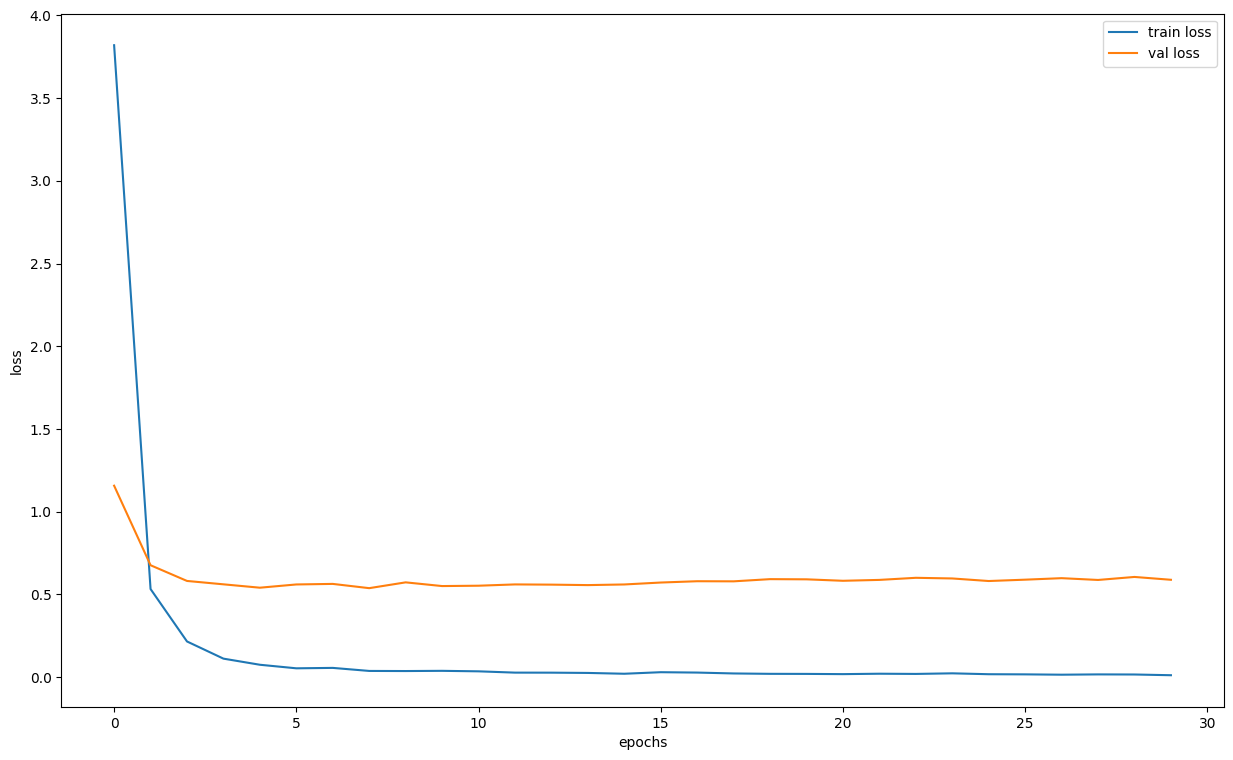

In [17]:
train_loss, train_accuracy, val_loss, val_accuracy = zip(*history) 
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [19]:
idx = list(map(int, np.random.uniform(0,500,100)))
imgs = [val_dataset[i][0].unsqueeze(0) for i in idx]
probs = predict(mobnet_model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = np.argmax(probs,-1)
actual_species = [val_dataset[i][1] for i in idx]
print("F1-score for MobileNet V2:", f1_score(actual_species, preds, average='micro'))

F1-score for MobileNet V2: 0.88


Not bad. Let's look at a random prediction of a validation dataset. 

Prediction: galapagos_penguin with confidence 100%


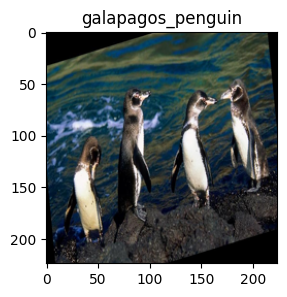

In [24]:
rand = int(np.random.uniform(0,500))
img, label = val_dataset[rand]
actual_species = val_dataset.label_encoder.inverse_transform([label])[0]
prob = predict_one(mobnet_model, img.unsqueeze(0))
predict_proba = np.max(prob)*100
    
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3, 3))
imshow(img.data.cpu(),title=actual_species,plt_ax=ax)
predicted_species = label_encoder.classes_[np.argmax(prob)]
print("Prediction: {} with confidence {:.0f}%".format(predicted_species,predict_proba)) 

Well, this was a correct guess. 

In [25]:
torch.save(mobnet_model, '/kaggle/working/mobnet_model.pth')

Let's now try to freeze all layers for training, but add custom classification on top, instead of the last layer. We will also try to use another loss function, namely, the negative log likelihood loss (NLLLoss). 

In [51]:
model = models.mobilenet_v2(pretrained=True)
model.aux_logits=False

for param in model.parameters():
    param.requires_grad = False
    
n_features = model.classifier[1].in_features

features = list(model.classifier.children())[:-1] 
features.extend([nn.Linear(n_features , 256),
                 nn.Dropout(0.3),
                 nn.ReLU(inplace=True), 
                 nn.Linear(256, 128),
                 nn.Dropout(0.3),
                 nn.ReLU(inplace=True), 
                 nn.Linear(128, 13),
                 nn.LogSoftmax(dim=1)]) 

model.classifier = nn.Sequential(*features) 
mobnet2_model = model.to(DEVICE)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

    
    history = []


    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.NLLLoss()
        
    
        for epoch in range(epochs):
            train_loss, train_accuracy = fit_epoch(model, train_loader, criterion, opt)
            #print("train loss: ", train_loss)
            val_loss, val_accuracy = eval_epoch(model, val_loader, criterion)
            #print("val loss: ", val_loss)

            history.append((train_loss, train_accuracy, val_loss, val_accuracy))
            pbar_outer.update(1)
            logs = "\nEpoch {ep} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
            tqdm.write(logs.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_accuracy, v_acc=val_accuracy))

    return history

In [53]:
history = train(train_dataset, val_dataset, model=mobnet2_model, epochs=80, batch_size=batch_size)

epoch:   0%|          | 0/80 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   1%|▏         | 1/80 [01:06<1:27:55, 66.77s/it]


Epoch 1 train_loss: 2.2062 val_loss 1.5519 train_acc 0.2503 val_acc 0.5241


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   2%|▎         | 2/80 [02:13<1:26:39, 66.65s/it]


Epoch 2 train_loss: 1.4311 val_loss 1.0970 train_acc 0.5159 val_acc 0.6277


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   4%|▍         | 3/80 [03:19<1:25:26, 66.57s/it]


Epoch 3 train_loss: 1.0797 val_loss 0.9324 train_acc 0.6291 val_acc 0.6995


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   5%|▌         | 4/80 [04:26<1:24:07, 66.42s/it]


Epoch 4 train_loss: 0.9329 val_loss 0.8247 train_acc 0.6926 val_acc 0.7241


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   6%|▋         | 5/80 [05:32<1:22:59, 66.39s/it]


Epoch 5 train_loss: 0.7915 val_loss 0.7604 train_acc 0.7409 val_acc 0.7467


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   8%|▊         | 6/80 [06:38<1:21:54, 66.42s/it]


Epoch 6 train_loss: 0.7176 val_loss 0.6521 train_acc 0.7583 val_acc 0.7826


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   9%|▉         | 7/80 [07:45<1:20:44, 66.36s/it]


Epoch 7 train_loss: 0.6579 val_loss 0.6180 train_acc 0.7764 val_acc 0.7785


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  10%|█         | 8/80 [08:51<1:19:40, 66.40s/it]


Epoch 8 train_loss: 0.6267 val_loss 0.6141 train_acc 0.7928 val_acc 0.7928


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  11%|█▏        | 9/80 [09:57<1:18:32, 66.38s/it]


Epoch 9 train_loss: 0.5918 val_loss 0.6092 train_acc 0.8051 val_acc 0.7856


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  12%|█▎        | 10/80 [11:04<1:17:24, 66.35s/it]


Epoch 10 train_loss: 0.5234 val_loss 0.5499 train_acc 0.8130 val_acc 0.8185


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  14%|█▍        | 11/80 [12:10<1:16:23, 66.42s/it]


Epoch 11 train_loss: 0.4980 val_loss 0.5292 train_acc 0.8277 val_acc 0.8205


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  15%|█▌        | 12/80 [13:16<1:15:10, 66.33s/it]


Epoch 12 train_loss: 0.4637 val_loss 0.5296 train_acc 0.8410 val_acc 0.8185


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  16%|█▋        | 13/80 [14:23<1:14:00, 66.28s/it]


Epoch 13 train_loss: 0.4603 val_loss 0.5011 train_acc 0.8438 val_acc 0.8267


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  18%|█▊        | 14/80 [15:29<1:12:57, 66.32s/it]


Epoch 14 train_loss: 0.4403 val_loss 0.5214 train_acc 0.8506 val_acc 0.8277


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  19%|█▉        | 15/80 [16:35<1:11:51, 66.33s/it]


Epoch 15 train_loss: 0.4125 val_loss 0.5208 train_acc 0.8639 val_acc 0.8215


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  20%|██        | 16/80 [17:41<1:10:40, 66.26s/it]


Epoch 16 train_loss: 0.3930 val_loss 0.5122 train_acc 0.8632 val_acc 0.8277


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  21%|██▏       | 17/80 [18:48<1:09:34, 66.27s/it]


Epoch 17 train_loss: 0.3697 val_loss 0.4654 train_acc 0.8762 val_acc 0.8256


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  22%|██▎       | 18/80 [19:54<1:08:25, 66.22s/it]


Epoch 18 train_loss: 0.3548 val_loss 0.4803 train_acc 0.8776 val_acc 0.8369


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  24%|██▍       | 19/80 [21:00<1:07:14, 66.13s/it]


Epoch 19 train_loss: 0.3348 val_loss 0.4703 train_acc 0.8838 val_acc 0.8379


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  25%|██▌       | 20/80 [22:06<1:06:14, 66.24s/it]


Epoch 20 train_loss: 0.3317 val_loss 0.4653 train_acc 0.8831 val_acc 0.8400


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  26%|██▋       | 21/80 [23:12<1:05:00, 66.10s/it]


Epoch 21 train_loss: 0.3338 val_loss 0.4736 train_acc 0.8875 val_acc 0.8390


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  28%|██▊       | 22/80 [24:18<1:03:44, 65.94s/it]


Epoch 22 train_loss: 0.3222 val_loss 0.4671 train_acc 0.8831 val_acc 0.8431


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  29%|██▉       | 23/80 [25:24<1:02:43, 66.02s/it]


Epoch 23 train_loss: 0.3253 val_loss 0.4617 train_acc 0.8824 val_acc 0.8400


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  30%|███       | 24/80 [26:30<1:01:39, 66.06s/it]


Epoch 24 train_loss: 0.2962 val_loss 0.4920 train_acc 0.8991 val_acc 0.8349


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  31%|███▏      | 25/80 [27:36<1:00:29, 65.98s/it]


Epoch 25 train_loss: 0.2899 val_loss 0.5039 train_acc 0.8995 val_acc 0.8421


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  32%|███▎      | 26/80 [28:42<59:19, 65.92s/it]  


Epoch 26 train_loss: 0.2562 val_loss 0.4450 train_acc 0.9080 val_acc 0.8564


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  34%|███▍      | 27/80 [29:47<58:06, 65.79s/it]


Epoch 27 train_loss: 0.2746 val_loss 0.4715 train_acc 0.9032 val_acc 0.8574


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  35%|███▌      | 28/80 [30:53<56:57, 65.73s/it]


Epoch 28 train_loss: 0.2330 val_loss 0.4550 train_acc 0.9214 val_acc 0.8646


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  36%|███▋      | 29/80 [31:58<55:55, 65.79s/it]


Epoch 29 train_loss: 0.2626 val_loss 0.4536 train_acc 0.9063 val_acc 0.8462


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  38%|███▊      | 30/80 [33:04<54:47, 65.75s/it]


Epoch 30 train_loss: 0.2738 val_loss 0.4682 train_acc 0.9046 val_acc 0.8544


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  39%|███▉      | 31/80 [34:10<53:39, 65.69s/it]


Epoch 31 train_loss: 0.2548 val_loss 0.4269 train_acc 0.9091 val_acc 0.8533


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  40%|████      | 32/80 [35:16<52:36, 65.77s/it]


Epoch 32 train_loss: 0.2097 val_loss 0.4691 train_acc 0.9234 val_acc 0.8544


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  41%|████▏     | 33/80 [36:21<51:31, 65.78s/it]


Epoch 33 train_loss: 0.2332 val_loss 0.4297 train_acc 0.9190 val_acc 0.8605


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  42%|████▎     | 34/80 [37:27<50:27, 65.82s/it]


Epoch 34 train_loss: 0.2245 val_loss 0.4671 train_acc 0.9227 val_acc 0.8492


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  44%|████▍     | 35/80 [38:33<49:24, 65.87s/it]


Epoch 35 train_loss: 0.2249 val_loss 0.4189 train_acc 0.9190 val_acc 0.8718


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  45%|████▌     | 36/80 [39:39<48:18, 65.88s/it]


Epoch 36 train_loss: 0.1960 val_loss 0.4778 train_acc 0.9279 val_acc 0.8636


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  46%|████▋     | 37/80 [40:45<47:11, 65.86s/it]


Epoch 37 train_loss: 0.2129 val_loss 0.4385 train_acc 0.9217 val_acc 0.8759


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  48%|████▊     | 38/80 [41:51<46:08, 65.92s/it]


Epoch 38 train_loss: 0.2112 val_loss 0.4721 train_acc 0.9262 val_acc 0.8646


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  49%|████▉     | 39/80 [42:57<45:05, 65.98s/it]


Epoch 39 train_loss: 0.1874 val_loss 0.4646 train_acc 0.9388 val_acc 0.8554


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  50%|█████     | 40/80 [44:03<43:56, 65.92s/it]


Epoch 40 train_loss: 0.1839 val_loss 0.4347 train_acc 0.9378 val_acc 0.8626


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  51%|█████▏    | 41/80 [45:09<42:49, 65.88s/it]


Epoch 41 train_loss: 0.1988 val_loss 0.4891 train_acc 0.9313 val_acc 0.8595


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  52%|█████▎    | 42/80 [46:15<41:43, 65.88s/it]


Epoch 42 train_loss: 0.2205 val_loss 0.4523 train_acc 0.9248 val_acc 0.8718


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  54%|█████▍    | 43/80 [47:21<40:37, 65.88s/it]


Epoch 43 train_loss: 0.1904 val_loss 0.4538 train_acc 0.9385 val_acc 0.8615


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  55%|█████▌    | 44/80 [48:26<39:29, 65.82s/it]


Epoch 44 train_loss: 0.1715 val_loss 0.4449 train_acc 0.9391 val_acc 0.8749


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  56%|█████▋    | 45/80 [49:32<38:23, 65.82s/it]


Epoch 45 train_loss: 0.1615 val_loss 0.4859 train_acc 0.9463 val_acc 0.8574


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  57%|█████▊    | 46/80 [50:38<37:18, 65.83s/it]


Epoch 46 train_loss: 0.1644 val_loss 0.5028 train_acc 0.9432 val_acc 0.8646


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  59%|█████▉    | 47/80 [51:44<36:14, 65.90s/it]


Epoch 47 train_loss: 0.1731 val_loss 0.4700 train_acc 0.9374 val_acc 0.8718


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  60%|██████    | 48/80 [52:50<35:11, 65.99s/it]


Epoch 48 train_loss: 0.1594 val_loss 0.4447 train_acc 0.9388 val_acc 0.8728


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  61%|██████▏   | 49/80 [53:56<34:03, 65.93s/it]


Epoch 49 train_loss: 0.1546 val_loss 0.4764 train_acc 0.9460 val_acc 0.8585


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  62%|██████▎   | 50/80 [55:02<32:56, 65.89s/it]


Epoch 50 train_loss: 0.1682 val_loss 0.4729 train_acc 0.9429 val_acc 0.8667


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  64%|██████▍   | 51/80 [56:08<31:49, 65.86s/it]


Epoch 51 train_loss: 0.1712 val_loss 0.4729 train_acc 0.9409 val_acc 0.8718


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  65%|██████▌   | 52/80 [57:13<30:42, 65.80s/it]


Epoch 52 train_loss: 0.1923 val_loss 0.4596 train_acc 0.9337 val_acc 0.8615


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  66%|██████▋   | 53/80 [58:19<29:39, 65.90s/it]


Epoch 53 train_loss: 0.1734 val_loss 0.4525 train_acc 0.9405 val_acc 0.8749


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  68%|██████▊   | 54/80 [59:26<28:35, 65.97s/it]


Epoch 54 train_loss: 0.1501 val_loss 0.4535 train_acc 0.9497 val_acc 0.8790


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  69%|██████▉   | 55/80 [1:00:31<27:26, 65.86s/it]


Epoch 55 train_loss: 0.1408 val_loss 0.4518 train_acc 0.9501 val_acc 0.8810


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  70%|███████   | 56/80 [1:01:37<26:18, 65.78s/it]


Epoch 56 train_loss: 0.1561 val_loss 0.4249 train_acc 0.9460 val_acc 0.8790


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  71%|███████▏  | 57/80 [1:02:43<25:16, 65.92s/it]


Epoch 57 train_loss: 0.1612 val_loss 0.5087 train_acc 0.9419 val_acc 0.8554


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  72%|███████▎  | 58/80 [1:03:48<24:07, 65.79s/it]


Epoch 58 train_loss: 0.1701 val_loss 0.4619 train_acc 0.9436 val_acc 0.8769


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  74%|███████▍  | 59/80 [1:04:54<22:59, 65.68s/it]


Epoch 59 train_loss: 0.1454 val_loss 0.4700 train_acc 0.9484 val_acc 0.8697


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  75%|███████▌  | 60/80 [1:06:00<21:54, 65.70s/it]


Epoch 60 train_loss: 0.1553 val_loss 0.4751 train_acc 0.9453 val_acc 0.8851


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  76%|███████▋  | 61/80 [1:07:05<20:49, 65.74s/it]


Epoch 61 train_loss: 0.1308 val_loss 0.4599 train_acc 0.9501 val_acc 0.8872


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  78%|███████▊  | 62/80 [1:08:11<19:43, 65.75s/it]


Epoch 62 train_loss: 0.1337 val_loss 0.4918 train_acc 0.9525 val_acc 0.8728


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  79%|███████▉  | 63/80 [1:09:17<18:36, 65.66s/it]


Epoch 63 train_loss: 0.1360 val_loss 0.5254 train_acc 0.9538 val_acc 0.8687


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  80%|████████  | 64/80 [1:10:22<17:29, 65.60s/it]


Epoch 64 train_loss: 0.1541 val_loss 0.4812 train_acc 0.9426 val_acc 0.8749


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  81%|████████▏ | 65/80 [1:11:28<16:23, 65.56s/it]


Epoch 65 train_loss: 0.1344 val_loss 0.4536 train_acc 0.9525 val_acc 0.8821


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  82%|████████▎ | 66/80 [1:12:33<15:17, 65.57s/it]


Epoch 66 train_loss: 0.1218 val_loss 0.5009 train_acc 0.9525 val_acc 0.8728


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  84%|████████▍ | 67/80 [1:13:39<14:13, 65.68s/it]


Epoch 67 train_loss: 0.1242 val_loss 0.4620 train_acc 0.9621 val_acc 0.8821


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  85%|████████▌ | 68/80 [1:14:45<13:09, 65.77s/it]


Epoch 68 train_loss: 0.1222 val_loss 0.4886 train_acc 0.9559 val_acc 0.8677


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  86%|████████▋ | 69/80 [1:15:52<12:06, 66.01s/it]


Epoch 69 train_loss: 0.1279 val_loss 0.5165 train_acc 0.9573 val_acc 0.8779


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  88%|████████▊ | 70/80 [1:16:58<10:59, 65.97s/it]


Epoch 70 train_loss: 0.1425 val_loss 0.5098 train_acc 0.9511 val_acc 0.8872


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  89%|████████▉ | 71/80 [1:18:04<09:55, 66.18s/it]


Epoch 71 train_loss: 0.1425 val_loss 0.4567 train_acc 0.9491 val_acc 0.8821


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  90%|█████████ | 72/80 [1:19:11<08:49, 66.24s/it]


Epoch 72 train_loss: 0.1243 val_loss 0.4923 train_acc 0.9590 val_acc 0.8800


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  91%|█████████▏| 73/80 [1:20:17<07:44, 66.42s/it]


Epoch 73 train_loss: 0.1234 val_loss 0.4895 train_acc 0.9559 val_acc 0.8769


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  92%|█████████▎| 74/80 [1:21:25<06:40, 66.68s/it]


Epoch 74 train_loss: 0.1168 val_loss 0.5266 train_acc 0.9590 val_acc 0.8687


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  94%|█████████▍| 75/80 [1:22:32<05:34, 66.94s/it]


Epoch 75 train_loss: 0.1160 val_loss 0.5010 train_acc 0.9583 val_acc 0.8841


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  95%|█████████▌| 76/80 [1:23:39<04:27, 66.95s/it]


Epoch 76 train_loss: 0.1143 val_loss 0.5043 train_acc 0.9545 val_acc 0.8759


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  96%|█████████▋| 77/80 [1:24:46<03:21, 67.03s/it]


Epoch 77 train_loss: 0.1126 val_loss 0.5143 train_acc 0.9583 val_acc 0.8769


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  98%|█████████▊| 78/80 [1:25:54<02:14, 67.12s/it]


Epoch 78 train_loss: 0.1144 val_loss 0.5436 train_acc 0.9579 val_acc 0.8728


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  99%|█████████▉| 79/80 [1:27:01<01:07, 67.27s/it]


Epoch 79 train_loss: 0.1223 val_loss 0.5136 train_acc 0.9549 val_acc 0.8779


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch: 100%|██████████| 80/80 [1:28:08<00:00, 66.11s/it]


Epoch 80 train_loss: 0.1209 val_loss 0.4994 train_acc 0.9569 val_acc 0.8769


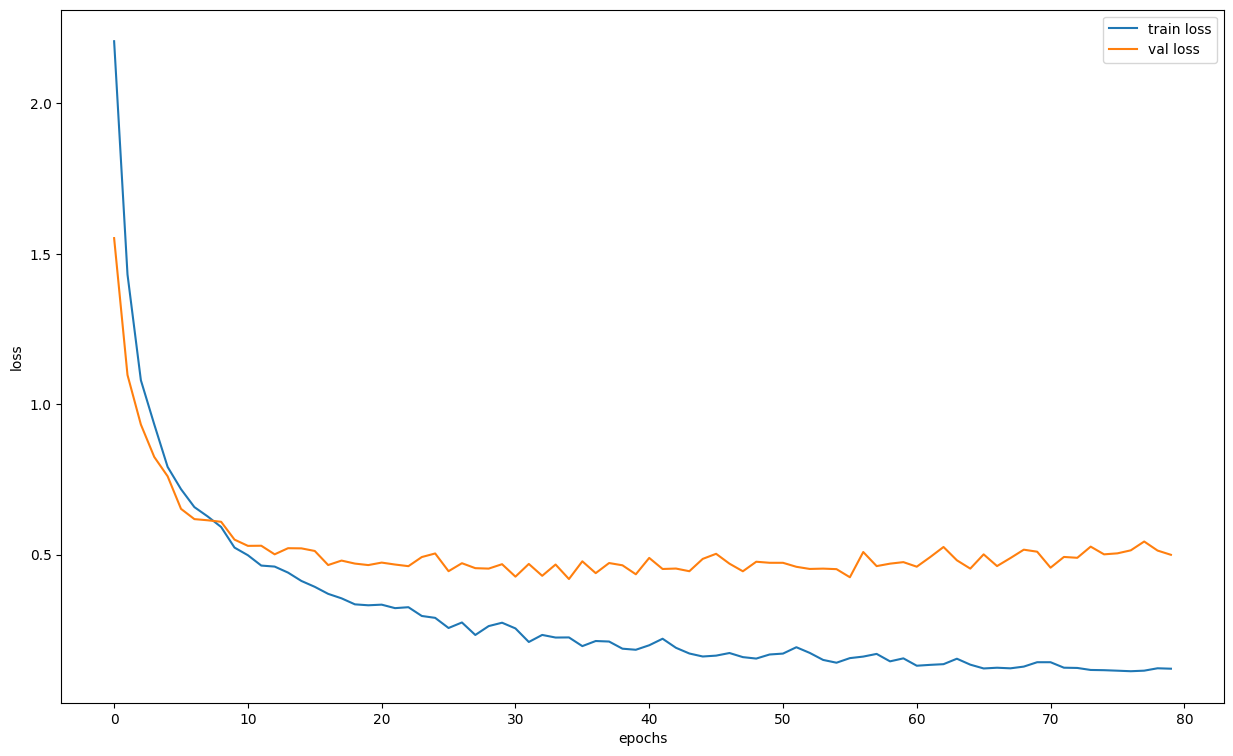

In [54]:
train_loss, train_accuracy, val_loss, val_accuracy = zip(*history) 
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [55]:
idx = list(map(int, np.random.uniform(0,500,100)))
imgs = [val_dataset[i][0].unsqueeze(0) for i in idx]
probs = predict(mobnet2_model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = np.argmax(probs,-1)
actual_species = [val_dataset[i][1] for i in idx]
print("F1-score for MobileNet V2 (updated):", f1_score(actual_species, preds, average='micro'))

F1-score for MobileNet V2 (updated): 0.85


In [57]:
torch.save(mobnet2_model, '/kaggle/working/mobnet_model2.pth')

## Resnet101

Let's add a suitable fully connected layer and freeze all other layers for training. 

In [14]:
model = models.resnet101(pretrained=True)

for param in model.parameters():
            param.requires_grad = False
        
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 13)

resnet101_model = model.to(DEVICE)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 214MB/s]  


This time we will try to use another optimizer, namely, gradient descent optimizer with momentum. So we will use a modified train function. 

In [15]:
params = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params.append(param)
        
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

    
    history = []


    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.SGD(params, lr=0.001, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        
    
        for epoch in range(epochs):
            train_loss, train_accuracy = fit_epoch(model, train_loader, criterion, opt)
            #print("train loss: ", train_loss)
            val_loss, val_accuracy = eval_epoch(model, val_loader, criterion)
            #print("val loss: ", val_loss)

            history.append((train_loss, train_accuracy, val_loss, val_accuracy))
            pbar_outer.update(1)
            logs = "\nEpoch {ep} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
            tqdm.write(logs.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_accuracy, v_acc=val_accuracy))

    return history

Training for 60 epochs: 

In [22]:
history = train(train_dataset, val_dataset, model=resnet101_model, epochs=60, batch_size=batch_size)

epoch:   0%|          | 0/60 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   2%|▏         | 1/60 [01:19<1:18:04, 79.40s/it]


Epoch 1 train_loss: 2.4820 val_loss 2.3497 train_acc 0.1675 val_acc 0.2810


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   3%|▎         | 2/60 [02:37<1:15:47, 78.40s/it]


Epoch 2 train_loss: 2.2255 val_loss 2.1200 train_acc 0.4021 val_acc 0.5344


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   5%|▌         | 3/60 [03:55<1:14:24, 78.32s/it]


Epoch 3 train_loss: 2.0133 val_loss 1.9311 train_acc 0.5703 val_acc 0.5990


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   7%|▋         | 4/60 [05:13<1:13:08, 78.36s/it]


Epoch 4 train_loss: 1.8388 val_loss 1.7773 train_acc 0.6315 val_acc 0.6328


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   8%|▊         | 5/60 [06:32<1:11:56, 78.49s/it]


Epoch 5 train_loss: 1.6867 val_loss 1.6465 train_acc 0.6728 val_acc 0.6677


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  10%|█         | 6/60 [07:50<1:10:35, 78.44s/it]


Epoch 6 train_loss: 1.5686 val_loss 1.5416 train_acc 0.6933 val_acc 0.6872


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  12%|█▏        | 7/60 [09:09<1:09:16, 78.42s/it]


Epoch 7 train_loss: 1.4689 val_loss 1.4539 train_acc 0.6947 val_acc 0.6964


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  13%|█▎        | 8/60 [10:28<1:08:12, 78.70s/it]


Epoch 8 train_loss: 1.3774 val_loss 1.3780 train_acc 0.7176 val_acc 0.7067


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  15%|█▌        | 9/60 [11:47<1:07:00, 78.83s/it]


Epoch 9 train_loss: 1.3059 val_loss 1.3148 train_acc 0.7265 val_acc 0.7046


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  17%|█▋        | 10/60 [13:06<1:05:41, 78.84s/it]


Epoch 10 train_loss: 1.2383 val_loss 1.2520 train_acc 0.7350 val_acc 0.7179


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  18%|█▊        | 11/60 [14:26<1:04:35, 79.10s/it]


Epoch 11 train_loss: 1.1800 val_loss 1.2048 train_acc 0.7525 val_acc 0.7179


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  20%|██        | 12/60 [15:45<1:03:24, 79.27s/it]


Epoch 12 train_loss: 1.1353 val_loss 1.1610 train_acc 0.7617 val_acc 0.7313


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  22%|██▏       | 13/60 [17:05<1:02:14, 79.45s/it]


Epoch 13 train_loss: 1.0940 val_loss 1.1212 train_acc 0.7641 val_acc 0.7446


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  23%|██▎       | 14/60 [18:25<1:00:59, 79.55s/it]


Epoch 14 train_loss: 1.0487 val_loss 1.0803 train_acc 0.7672 val_acc 0.7426


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  25%|██▌       | 15/60 [19:45<59:49, 79.77s/it]  


Epoch 15 train_loss: 1.0233 val_loss 1.0536 train_acc 0.7709 val_acc 0.7497


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  27%|██▋       | 16/60 [21:05<58:36, 79.92s/it]


Epoch 16 train_loss: 0.9855 val_loss 1.0280 train_acc 0.7771 val_acc 0.7426


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  28%|██▊       | 17/60 [22:25<57:10, 79.79s/it]


Epoch 17 train_loss: 0.9510 val_loss 1.0008 train_acc 0.7836 val_acc 0.7641


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  30%|███       | 18/60 [23:46<56:02, 80.05s/it]


Epoch 18 train_loss: 0.9248 val_loss 0.9801 train_acc 0.7973 val_acc 0.7456


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  32%|███▏      | 19/60 [25:06<54:40, 80.00s/it]


Epoch 19 train_loss: 0.9000 val_loss 0.9551 train_acc 0.7959 val_acc 0.7610


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  33%|███▎      | 20/60 [26:25<53:15, 79.90s/it]


Epoch 20 train_loss: 0.8761 val_loss 0.9327 train_acc 0.8014 val_acc 0.7631


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  35%|███▌      | 21/60 [27:44<51:45, 79.63s/it]


Epoch 21 train_loss: 0.8620 val_loss 0.9141 train_acc 0.7976 val_acc 0.7744


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  37%|███▋      | 22/60 [29:03<50:16, 79.39s/it]


Epoch 22 train_loss: 0.8370 val_loss 0.8946 train_acc 0.8007 val_acc 0.7764


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  38%|███▊      | 23/60 [30:23<49:00, 79.46s/it]


Epoch 23 train_loss: 0.8120 val_loss 0.8800 train_acc 0.8126 val_acc 0.7703


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  40%|████      | 24/60 [31:42<47:38, 79.41s/it]


Epoch 24 train_loss: 0.7961 val_loss 0.8579 train_acc 0.8082 val_acc 0.7795


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  42%|████▏     | 25/60 [33:01<46:18, 79.40s/it]


Epoch 25 train_loss: 0.7843 val_loss 0.8509 train_acc 0.8164 val_acc 0.7785


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  43%|████▎     | 26/60 [34:21<45:03, 79.52s/it]


Epoch 26 train_loss: 0.7670 val_loss 0.8331 train_acc 0.8157 val_acc 0.7815


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  45%|████▌     | 27/60 [35:41<43:45, 79.56s/it]


Epoch 27 train_loss: 0.7498 val_loss 0.8222 train_acc 0.8222 val_acc 0.7877


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  47%|████▋     | 28/60 [37:01<42:30, 79.70s/it]


Epoch 28 train_loss: 0.7321 val_loss 0.8118 train_acc 0.8232 val_acc 0.7836


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  48%|████▊     | 29/60 [38:21<41:16, 79.88s/it]


Epoch 29 train_loss: 0.7171 val_loss 0.7987 train_acc 0.8311 val_acc 0.7887


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  50%|█████     | 30/60 [39:40<39:47, 79.58s/it]


Epoch 30 train_loss: 0.7052 val_loss 0.7848 train_acc 0.8373 val_acc 0.7918


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  52%|█████▏    | 31/60 [40:59<38:23, 79.43s/it]


Epoch 31 train_loss: 0.6961 val_loss 0.7755 train_acc 0.8332 val_acc 0.7969


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  53%|█████▎    | 32/60 [42:19<37:05, 79.49s/it]


Epoch 32 train_loss: 0.6801 val_loss 0.7684 train_acc 0.8338 val_acc 0.7959


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  55%|█████▌    | 33/60 [43:38<35:42, 79.34s/it]


Epoch 33 train_loss: 0.6785 val_loss 0.7573 train_acc 0.8356 val_acc 0.7990


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  57%|█████▋    | 34/60 [44:57<34:23, 79.36s/it]


Epoch 34 train_loss: 0.6610 val_loss 0.7500 train_acc 0.8386 val_acc 0.8000


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  58%|█████▊    | 35/60 [46:16<32:59, 79.18s/it]


Epoch 35 train_loss: 0.6549 val_loss 0.7387 train_acc 0.8356 val_acc 0.7949


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  60%|██████    | 36/60 [47:35<31:39, 79.16s/it]


Epoch 36 train_loss: 0.6480 val_loss 0.7305 train_acc 0.8400 val_acc 0.7979


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  62%|██████▏   | 37/60 [48:53<30:14, 78.89s/it]


Epoch 37 train_loss: 0.6356 val_loss 0.7297 train_acc 0.8424 val_acc 0.7990


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  63%|██████▎   | 38/60 [50:12<28:55, 78.88s/it]


Epoch 38 train_loss: 0.6187 val_loss 0.7195 train_acc 0.8485 val_acc 0.8000


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  65%|██████▌   | 39/60 [51:31<27:36, 78.90s/it]


Epoch 39 train_loss: 0.6157 val_loss 0.7076 train_acc 0.8496 val_acc 0.8051


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  67%|██████▋   | 40/60 [52:51<26:23, 79.16s/it]


Epoch 40 train_loss: 0.6055 val_loss 0.7010 train_acc 0.8523 val_acc 0.8000


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  68%|██████▊   | 41/60 [54:11<25:09, 79.46s/it]


Epoch 41 train_loss: 0.6017 val_loss 0.7020 train_acc 0.8496 val_acc 0.8010


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  70%|███████   | 42/60 [55:30<23:50, 79.49s/it]


Epoch 42 train_loss: 0.5928 val_loss 0.6893 train_acc 0.8540 val_acc 0.8051


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  72%|███████▏  | 43/60 [56:50<22:32, 79.55s/it]


Epoch 43 train_loss: 0.5850 val_loss 0.6862 train_acc 0.8581 val_acc 0.7990


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  73%|███████▎  | 44/60 [58:10<21:13, 79.61s/it]


Epoch 44 train_loss: 0.5754 val_loss 0.6770 train_acc 0.8588 val_acc 0.8062


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  75%|███████▌  | 45/60 [59:29<19:53, 79.58s/it]


Epoch 45 train_loss: 0.5683 val_loss 0.6731 train_acc 0.8574 val_acc 0.8062


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  77%|███████▋  | 46/60 [1:00:49<18:34, 79.61s/it]


Epoch 46 train_loss: 0.5559 val_loss 0.6620 train_acc 0.8629 val_acc 0.8123


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  78%|███████▊  | 47/60 [1:02:09<17:14, 79.61s/it]


Epoch 47 train_loss: 0.5596 val_loss 0.6574 train_acc 0.8612 val_acc 0.8082


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  80%|████████  | 48/60 [1:03:29<15:57, 79.76s/it]


Epoch 48 train_loss: 0.5476 val_loss 0.6513 train_acc 0.8591 val_acc 0.8123


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  82%|████████▏ | 49/60 [1:04:49<14:38, 79.87s/it]


Epoch 49 train_loss: 0.5457 val_loss 0.6527 train_acc 0.8632 val_acc 0.8123


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  83%|████████▎ | 50/60 [1:06:09<13:19, 79.96s/it]


Epoch 50 train_loss: 0.5325 val_loss 0.6448 train_acc 0.8609 val_acc 0.8154


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  85%|████████▌ | 51/60 [1:07:29<12:00, 80.02s/it]


Epoch 51 train_loss: 0.5319 val_loss 0.6405 train_acc 0.8609 val_acc 0.8113


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  87%|████████▋ | 52/60 [1:08:49<10:40, 80.06s/it]


Epoch 52 train_loss: 0.5220 val_loss 0.6388 train_acc 0.8766 val_acc 0.8174


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  88%|████████▊ | 53/60 [1:10:09<09:20, 80.03s/it]


Epoch 53 train_loss: 0.5196 val_loss 0.6302 train_acc 0.8725 val_acc 0.8154


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  90%|█████████ | 54/60 [1:11:29<08:00, 80.03s/it]


Epoch 54 train_loss: 0.5161 val_loss 0.6269 train_acc 0.8687 val_acc 0.8051


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  92%|█████████▏| 55/60 [1:12:49<06:39, 79.99s/it]


Epoch 55 train_loss: 0.5098 val_loss 0.6221 train_acc 0.8735 val_acc 0.8174


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  93%|█████████▎| 56/60 [1:14:10<05:20, 80.22s/it]


Epoch 56 train_loss: 0.5033 val_loss 0.6174 train_acc 0.8800 val_acc 0.8226


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  95%|█████████▌| 57/60 [1:15:30<04:00, 80.27s/it]


Epoch 57 train_loss: 0.4928 val_loss 0.6152 train_acc 0.8773 val_acc 0.8174


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  97%|█████████▋| 58/60 [1:16:50<02:40, 80.18s/it]


Epoch 58 train_loss: 0.4904 val_loss 0.6125 train_acc 0.8797 val_acc 0.8133


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  98%|█████████▊| 59/60 [1:18:10<01:20, 80.07s/it]


Epoch 59 train_loss: 0.4900 val_loss 0.6063 train_acc 0.8759 val_acc 0.8236


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch: 100%|██████████| 60/60 [1:19:30<00:00, 79.50s/it]


Epoch 60 train_loss: 0.4821 val_loss 0.6035 train_acc 0.8824 val_acc 0.8256


As usually, let's plot the losses and calculate the F1 score. 

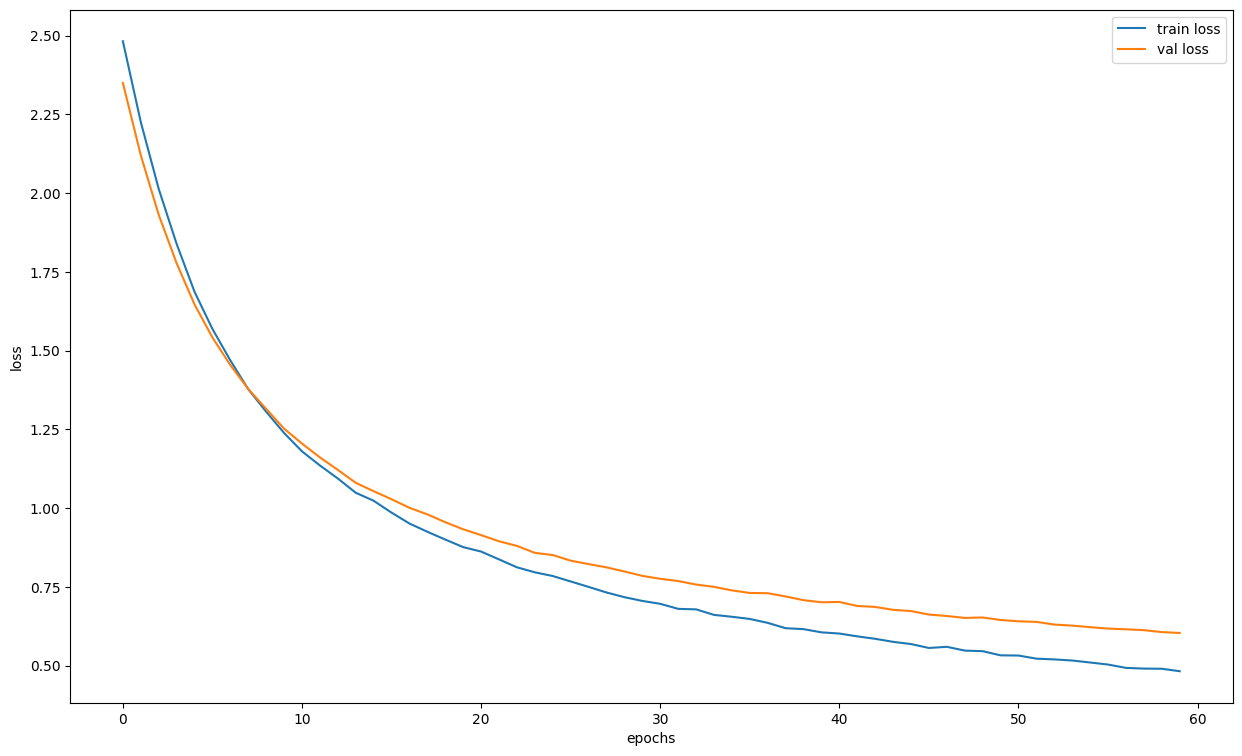

In [23]:
train_loss, train_accuracy, val_loss, val_accuracy = zip(*history) 
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [24]:
idx = list(map(int, np.random.uniform(0,500,100)))
imgs = [val_dataset[i][0].unsqueeze(0) for i in idx]
probs = predict(resnet101_model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = np.argmax(probs,-1)
actual_species = [val_dataset[i][1] for i in idx]
print("F1-score for Resnet101:", f1_score(actual_species, preds, average='micro'))

F1-score for MobileNet V2 (updated): 0.8399999999999999


## Using the model for prediction 

Here we will write some code that is later to be exported as a separate script. 

In [61]:
model = torch.load('mobnet_model.pth').cpu()

def get_image(url):
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))
    image.load()
    image = image.convert('RGB').resize((img_size, img_size))
    preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    X = np.array(image)
    X = np.array(X / 255, dtype='float32')
    X = preprocess(X) 
    return X

In [62]:
img_size = 224
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Aptenodytes_forsteri_-Snow_Hill_Island%2C_Antarctica_-adults_and_juvenile-8.jpg/640px-Aptenodytes_forsteri_-Snow_Hill_Island%2C_Antarctica_-adults_and_juvenile-8.jpg"
img = get_image(url)

def predict_one(model, inputs):
    with torch.no_grad():
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs


label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
prob = predict_one(model, img.unsqueeze(0))
predict_proba = np.max(prob)*100
predicted_species = label_encoder.classes_[np.argmax(prob)]

Prediction: emperor_penguin with confidence 100%


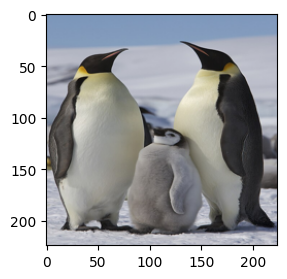

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3, 3))
imshow(img.data.cpu(),title='',plt_ax=ax)
predicted_species = label_encoder.classes_[np.argmax(prob)]
print("Prediction: {} with confidence {:.0f}%".format(predicted_species,predict_proba)) 